In [4]:
from PIL import Image
import numpy as np
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats,ndimage
import re
import wget

%matplotlib inline

BASE = "Data/Gruppe4-27-12/"
VERSUCH1 = "Versuch1"
VERSUCH2 = "Versuch2"
HELL = "Hell"
DUNKEL = "Dunkel"

V1 = os.path.join(BASE,VERSUCH1)
V2 = os.path.join(BASE,VERSUCH2)

# Kamera Auflösung
N = 1600
M = 1200

# Mittlere anzahl an einfallenden Photonen
CONSTANT = 5.034e24

# Wellenlänge
WAVELENGTH = 520e-9

# Pixelgröße des Sensors
PIXEL_SIZE = (4.5e-6)**2

# Spektrometer Kalibrierschein
#AW = 0.30609
#AW = 0.2927
AW = 0.3192


QUANTISATION_ERR_VAR = 1/12
# 

A = 43.91e-8
#A = 6819e-10

PIXEL_PHOTO = 0.007**2


E =  (A) / (PIXEL_PHOTO * AW)

# IN Milisekunden
BELICHTUNGSZEITEN = np.array([
                    0.02,
                    0.06,
                    0.120,
                    0.180,
                    0.240,
                    0.300,
                    0.360,
                    0.400,
                    0.500,
                    0.600,
                    0.700,
                    0.800,
                    0.900,
                    1.000,
                    1.500,
                    2.000,
                    2.500,
                    3.000,
                    4.000,
                    4.500,
                    5.000,
                    5.500,
                    6.000,
                    6.500,
                    7.000,
                    7.500,
                    8.000,
                    8.300,
                    8.600,
                    9.000]) * 1e-3

print(E)

#I = 1.5#0.8 #mA
#AperW = 0.3069
#E = ((10**(-6)*I)/0.0001) / AperW
#((46.85*10**(-9)) / 0.3069) / 0.00001#(0.196*(10**(-6))) #0.0001
print("E", E)

0.02807401155951102
E 0.02807401155951102


In [6]:

I = 1.5#0.8 #mA
AperW = 0.3069
#E = ((10**(-6)*I)/0.0001) / AperW
print(E)


0.02807401155951102


In [3]:

def get_imgs(path,pattern=".*_([\d]+)_.*\.png"):
    files_raw = glob.glob(os.path.join(path,"*.png"))
    files_sorted = []
    for f in files_raw:
        matches = re.search(pattern, f, re.DOTALL)
        if matches:
            files_sorted.append((int(matches[1]),f))
    files_sorted = sorted(files_sorted, key=lambda tup: tup[0])
    return files_sorted

def add_exposuretime(array):
    new_array = [ (BELICHTUNGSZEITEN[i//2],array[i][1],array[i+1][1]) for i in range(0,len(array),2)]
    return new_array

def mean_photons(exposure_times):
    return CONSTANT * PIXEL_SIZE * E * exposure_times * WAVELENGTH

def mean_gray(img1,img2):
    return (1/(2*N*M)) * ((img1.astype(np.uint32)+img2.astype(np.uint32)).sum())

    
def temporal_rush(img1,img2):
    return (1/(2*N*M)) * (((img1.astype(np.int32)-img2.astype(np.int32))**2).sum())

def open_img(path):
    return np.array(Image.open(path),dtype='uint16')

def regression(x,y):
    slope, intercept, r_value, p_value, std_err= stats.linregress(x,y)
    return slope,intercept

def average_over_images(stack):
    avg = np.zeros((M,N),dtype=np.int64)
    for nbr,img in stack:
        #img = np.array(Image.open(img),dtype=np.uint32)
        img = np.array(Image.open(img),dtype=np.uint16)
        avg += img

    avg = avg / len(stack)
    
    return avg

In [4]:
hell = get_imgs(os.path.join(V1,HELL))
dunkel = get_imgs(os.path.join(V1,DUNKEL))

hell = add_exposuretime(hell)
dunkel = add_exposuretime(dunkel)

hell_imgs = [ (open_img(img1),open_img(img2)) for exp,img1,img2 in hell ]
dunkel_imgs = [ (open_img(img1),open_img(img2)) for exp,img1,img2 in dunkel ]


## Aufgabe 1


### a)

Messen Sie die Bestrahlungsstärke $E$ der Lichtquelle in $\frac{W}{m^2}$ mit dem Photometer in gleichem Abstand wie die Kamera. Achten Sie dabei auf den korrekten Umrechnungs-faktor für die Wellenlänge der Leuchtdiode. Mit der Pixelfläche $A$, der Wellenlänge $λ$ der Leuchtdiode und der Belichtungszeit können Sie so die mittlere Anzahl der einfallenden Photonen berechnen (s. Vorl.2/5).


### Antwort:

Kalibrierschein für $λ = 510 nm \Rightarrow 0,2927 \frac{A}{W}$

Fläche des Photometersensors = $(0.007m)^2$

Gemessen mit Photometer: $43,91 \cdot 10^{-6} A$

\begin{equation}
\Rightarrow \frac{43,91\cdot 10^{-6} A }{0,2927 \frac{A}{W} * (0,007m)^2} = 3,06 \frac{W}{m^2}
\end{equation}

### b)

Nehmen Sie mindestens 9 verschiedene Belichtungszeiten. Für jede Belichtungszeitwerden 4 Bilder aufgenommen, je zwei von der Ulbrichtkugel und je zwei bei abgedeckter Kamera. Bestimmen Sie den Sättigungspunkt der Kamera, d.h. die maximaleBelichtungszeit, ab der die Pixelvarianz wieder abzunehmen beginnt (s. Vorl. 2/15)

In [5]:
nbr_mean_photons = mean_photons(np.array(BELICHTUNGSZEITEN))

mu_black  = np.array([mean_gray(img1,img2) for (img1,img2) in dunkel_imgs ])
mu_white  = np.array([mean_gray(img1,img2) for (img1,img2) in hell_imgs ])
tv_black  = np.array([temporal_rush(img1,img2) for (img1,img2) in dunkel_imgs ])
tv_white  = np.array([temporal_rush(img1,img2) for (img1,img2) in hell_imgs ])

In [6]:
mu_black_white = mu_white - mu_black
tv_black_white = tv_white - tv_black

# 70% von Zeitlicher Varianz (Photonentransfer)
Saturation = np.max(tv_black_white)
idx_sat = np.where(tv_black_white == Saturation)[0][0]
idx_70percent_sat = np.where(tv_black_white[:idx_sat+1] <= (Saturation * 0.7) )[0][-1]

K,b_K = regression(mu_black_white[:idx_70percent_sat+1],tv_black_white[:idx_70percent_sat+1])

# 70% von Mittlerer Grauwert (Sensitivität)

Saturation_mu = np.max(mu_black_white)
idx_sat_mu = np.where(mu_black_white == Saturation_mu)[0][0]
idx_70percent_sat_mu = np.where(mu_black_white[:idx_sat_mu+1] <= (Saturation_mu * 0.7) )[0][-1]

R,b_R = regression(nbr_mean_photons[:idx_70percent_sat_mu+1],mu_black_white[:idx_70percent_sat_mu+1])


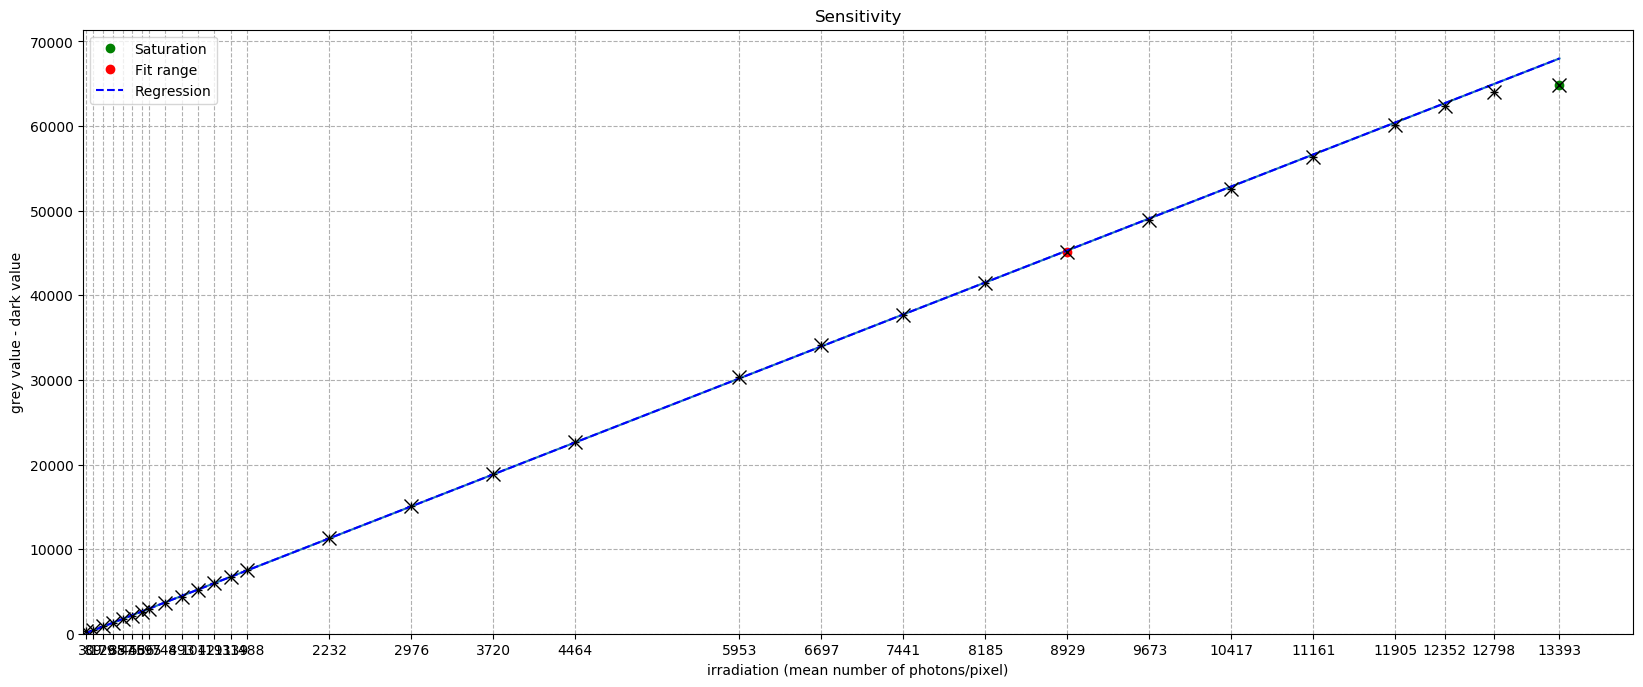

In [7]:
plt.figure(figsize=(20,8),dpi=100,facecolor='w', edgecolor='k')
plt.plot(nbr_mean_photons,b_R+R*nbr_mean_photons)
plt.plot(nbr_mean_photons,mu_black_white,'+',color='black')
plt.xticks(nbr_mean_photons)
plt.plot(nbr_mean_photons[idx_sat_mu],mu_black_white[idx_sat_mu],'o',color = 'g',label='Saturation')
plt.plot(nbr_mean_photons[idx_70percent_sat_mu],mu_black_white[idx_70percent_sat_mu],'o',color="r",label='Fit range')
plt.plot(nbr_mean_photons,b_R+(R*nbr_mean_photons),'--',color="b",label="Regression")
plt.plot(nbr_mean_photons,mu_black_white,'x',color="black",markersize=10)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend(loc='upper left')
plt.ylabel("grey value - dark value")
plt.xlabel("irradiation (mean number of photons/pixel)")
plt.title("Sensitivity")
plt.grid(linestyle="--")
plt.show()

### c)

Verwenden Sie die Photonentransfermethode nach EMVA 1288, um eine Sensitivitäts-und eine Photonentransferkurve zu erstellen. Schauen Sie sich dazu die Beispiele inden Vorlesungsunterlagen bzw. in der EMVA 1288 an

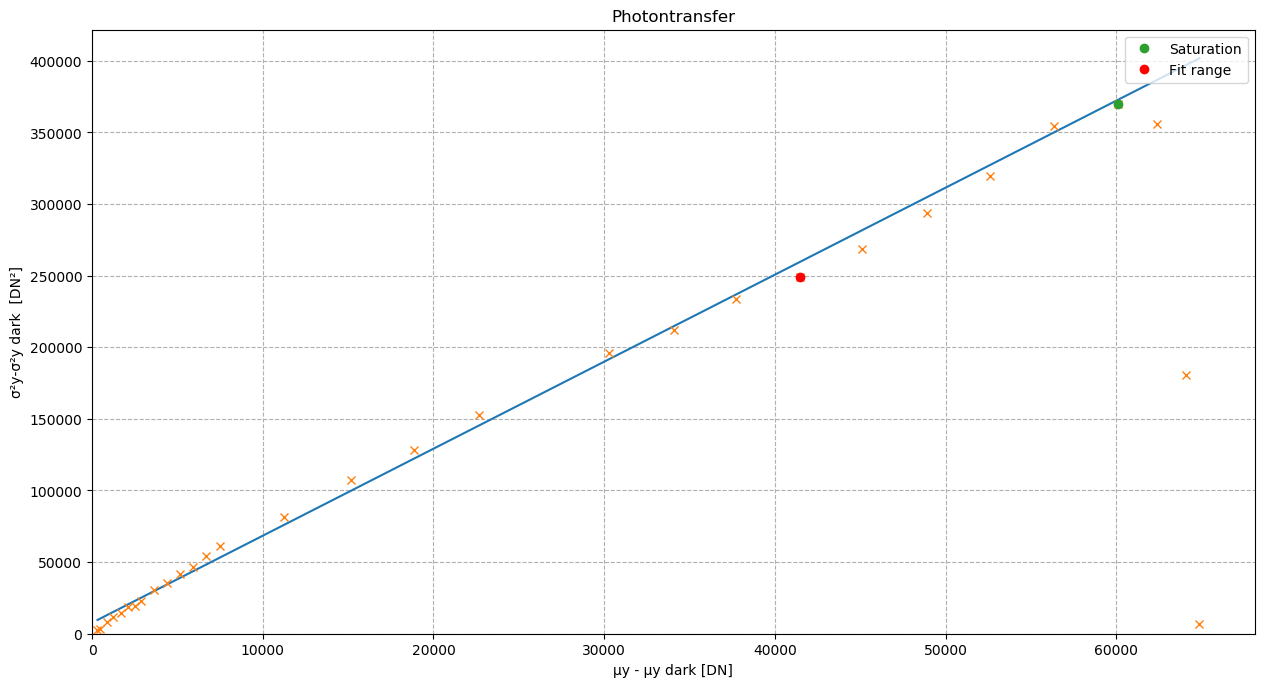

In [8]:
plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.plot(mu_black_white,b_K+(K*mu_black_white))
plt.plot(mu_black_white,tv_black_white,'x')
plt.plot(mu_black_white[idx_sat],tv_black_white[idx_sat],'o',label='Saturation')
plt.plot(mu_black_white[idx_70percent_sat],tv_black_white[idx_70percent_sat],'o',color="r",label='Fit range')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend(loc='upper right')
plt.ylabel("\u03C3²y-\u03C3²y dark  [DN²]")
plt.xlabel("\u03BCy - \u03BCy dark [DN]")
plt.title("Photontransfer")
plt.grid(linestyle="--")
plt.show()

### d) 
Bestimmen Sie die Responsivität R, Kameraverstärkung K, Quanteneffizienz η und
das Dunkelsignal $\sigma^2_d$ , wie in der Vorlesung gezeigt.
\begin{equation}
\begin{aligned}
\sigma^2_d &= \frac{\sigma^2_{y,dark}-\sigma^2_q}{K^2}\\
\sigma^2_q &= \frac{1}{12}
\end{aligned}
\end{equation}


In [9]:
sigma_y_dark = mu_black[0]

if sigma_y_dark < 0.24:
    sigma_y_dark = 0.49
    

sigma_dunkel = (sigma_y_dark - QUANTISATION_ERR_VAR) / K**2
Q_E = R/K
print("K\t\t\t: {:.4f}".format(K))
print("Responsivität R\t\t: {:.2E}".format(R))
print("Quanteneffizienz = R/K\t: {:.2E}".format(Q_E))
print("Sigma dunkel \t\t: {:.4E}".format(sigma_dunkel))

K			: 6.0753
Responsivität R		: 5.08E+00
Quanteneffizienz = R/K	: 8.37E-01
Sigma dunkel 		: 1.3045E+01


## Aufgabe 2: Kennzahlen zur Bewertung der Kamera

### a) 

    Bestimmen Sie aus den für Aufgabe 1 aufgenommenen Daten die SNR-Kurve der Kamera und tragen Sie diese wie in der Vorlesung in einem doppelt logarithmischen Diagramm auf (s.Vorl. 2/20).

\begin{equation}
    SNR=\frac{\mu_y - \mu_{y,dark}}{\sigma_y}
\end{equation}

---

### b)

    Zeichnen Sie den Sättigungspunkt und die kleinste nutzbare Bestrahlungsstärke (s.Vorlesung) ein, außerdem die SNR-Kurve des idealen Sensors und die theoretische SNR-Kurve, wie sie sich aus den in Aufgabe 1 bestimmten Parametern ergibt (Vorl.2/18).



    Idealer Sensor hat Quanteneffizienz 1 und kein Rauschen:



\begin{equation}
    SNR_{ideal}=\sqrt{\mu_p}
\end{equation}


Die kleinste nutzbare Bestrahlungsstärke $\mu_{min}$ ist der Punkt an dem SNR=1:

\begin{equation}
    \mu_p(SNR = 1)= \frac{1}{\eta} ( \frac{\sigma_{y,dark}}{K} + \frac{1}{2})
\end{equation}


Der Sättigungspunkt $\mu_{max}$ ist das maximum der Varianz (in Aufgabe 1 berechnet)


    Die Theoretische SNR berechnet sich wie folgt:


\begin{equation}
    SNR_{theo}=\frac{\eta \mu_p}{\sqrt{ \sigma^2_d + \sigma^2_q / K^2 + \eta \mu_p}}
\end{equation}

---

### c)

    Bestimmen Sie den Dynamikbereich Ihrer Kamera. Vergleichen Sie Ihre Ergebnissemit den anderen Gruppen. Welche Kamera ist besser?

    Der Dynamikbereich ist definiert als:

\begin{equation}
    DR=\frac{\mu_{min}}{\mu_{max}}
\end{equation}

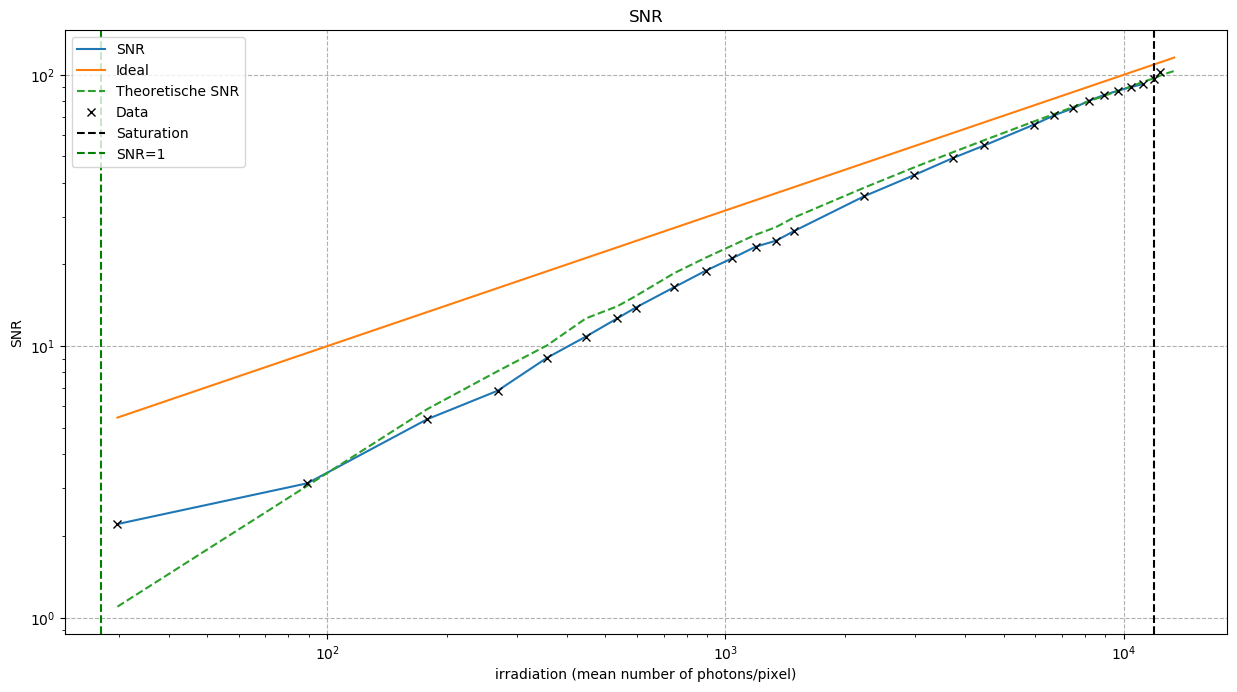

Dynamik Range : 52.87 db


In [10]:
# SNR
#x = [0] + list(nbr_mean_photons)
SNR = ( mu_white - mu_black ) / (np.sqrt(tv_white))

# SNR_ideal

SNR_IDEAL = np.sqrt(nbr_mean_photons)


sigma_dark = (tv_black - QUANTISATION_ERR_VAR)/K**2


SNR_THEO = (Q_E * nbr_mean_photons) / (np.sqrt( sigma_dark + (Q_E * nbr_mean_photons) )) 


# Sättigungspunkt (Anzahl durchschn. photonen)
mu_max = nbr_mean_photons[idx_sat]



mu_min = (1 / Q_E) * ( (np.sqrt(tv_black[0])/K) + 0.5 ) 

DR = 20*np.log10(mu_max/mu_min)

plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.loglog(nbr_mean_photons[:idx_sat],SNR[:idx_sat],label="SNR")
plt.loglog(nbr_mean_photons,SNR_IDEAL,label="Ideal")
plt.loglog(nbr_mean_photons,SNR_THEO,linestyle='--',label="Theoretische SNR")
plt.loglog(nbr_mean_photons[:-2],SNR[:-2],'x',c='black',label="Data")
plt.axvline(x=mu_max, color='k', linestyle='--',label="Saturation")
plt.axvline(x=mu_min, color="green",linestyle='--',label="SNR=1")
plt.legend(loc='upper left')
plt.grid(linestyle="--")
plt.ylabel("SNR")
plt.xlabel("irradiation (mean number of photons/pixel)")
plt.title("SNR")
plt.show()

print("Dynamik Range : {:.2f} db".format(DR))

# Aufgabe 3: Räumliche Inhomogenitäten


Nehmen Sie einen Satz von mindestens 16 Bildern bei 50% des Sättigungswertes und mindestens 16 Bilder bei abgedeckter Kamera auf. Verwenden Sie dabei für beide Bildersätze die gleiche Belichtungszeit.

---

### a)

    Berechnen Sie daraus ein Weißbild und ein Dunkelbild

---

### b)

    Berechnen Sie DSNU und PRNU nach EMVA 1288 Ihrer Kamera.

---

### c)

    Berechnen Sie die horizontalen und vertikalen Spektrogramme und stellen Sie diese so
    wie in der Vorlesung dar. Hat Ihre Kamera periodische Inhomogenitäten?

---

In [11]:

dunkel_stack = get_imgs(V2,pattern="50_Dunkel_([\d]+)_.*\.png")
hell_stack = get_imgs(V2,pattern="50_Hell_([\d]+)_.*\.png")

# Weißbild
y50_meanimg = average_over_images(hell_stack)

# Dunkelbild
y50_dark_meanimg = average_over_images(dunkel_stack)



In [12]:
# Mittelwert der durchschnittsbilder

mu50_dark = y50_dark_meanimg.mean()
mu50_y    = y50_meanimg.mean()

def spatial_varianz(img):
    mean = img.mean()
    spatial = 0
    for i in range(M):
        for j in range(N):
            spatial += (img[i,j] - mean)**2
    return spatial /( (M*N) - 1)

def sigma_square(img_stack):
    mean = average_over_images(img_stack)
    sum = np.zeros(mean.shape,dtype=np.float64)
    
    for nbr,img in img_stack:
        img = np.array(Image.open(img),dtype=np.int32)
        sum += (img - mean)**2
       
    return sum / (len(img_stack) - 1)

def sigma_stack(img_stack):
    square = sigma_square(img_stack)
    return square.mean()
    


sigma2_dunkel_stack = sigma_stack(dunkel_stack)
sigma2_hell_stack = sigma_stack(hell_stack)

s2_y = y50_meanimg - ( sigma2_hell_stack / len(dunkel_stack) )
s2_y_dark = y50_dark_meanimg - ( sigma2_dunkel_stack / len(dunkel_stack) )

Sydark = spatial_varianz(s2_y_dark)
Sy = spatial_varianz(s2_y)



In [28]:
DSNU = np.sqrt(Sydark) / K
PRNU = np.sqrt(Sy - Sydark) / (mu50_y - mu50_dark)


# korrektur mit varianz

#y50_dark_meanimg = y50_dark_meanimg - temporal_rush()

y_dark_img = y50_dark_meanimg - y50_dark_meanimg.mean()
y_img = (y50_meanimg - y50_dark_meanimg)
y_img = y_img - y_img.mean()


def spektral_power(y,axis=0):
    M = y.shape[axis]
    return  (y * np.conjugate(y) ).sum(axis=axis) / M
    
def calc_fft(img):
    M,N = img.shape

    
    img_fft_V = np.fft.fft(img,axis=0) / np.sqrt(N)
    img_fft_H = np.fft.fft(img,axis=1) / np.sqrt(M)
    
    img_fft_H = ( img_fft_H * np.conjugate(img_fft_H) ).sum(axis=0) / N
    img_fft_V = ( img_fft_V * np.conjugate(img_fft_V) ).sum(axis=1) / M
    
    
    
    return np.sqrt(img_fft_H[:]),np.sqrt(img_fft_V[:])
    
    
fft_y_H,fft_y_V = calc_fft(y_img)

fft_ydark_H,fft_ydark_V = calc_fft(y_dark_img)



#fft_y_H,fft_y_V = calc_fft(y50_meanimg)
#fft_ydark_H,fft_ydark_V = calc_fft(y50_dark_meanimg)

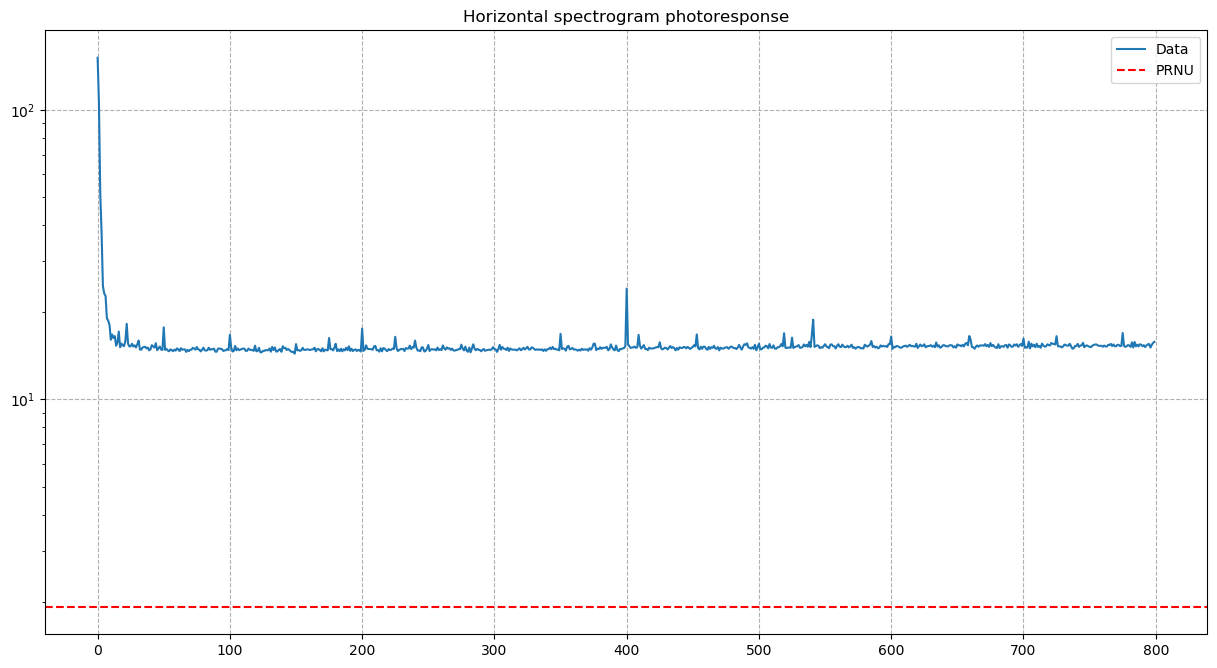

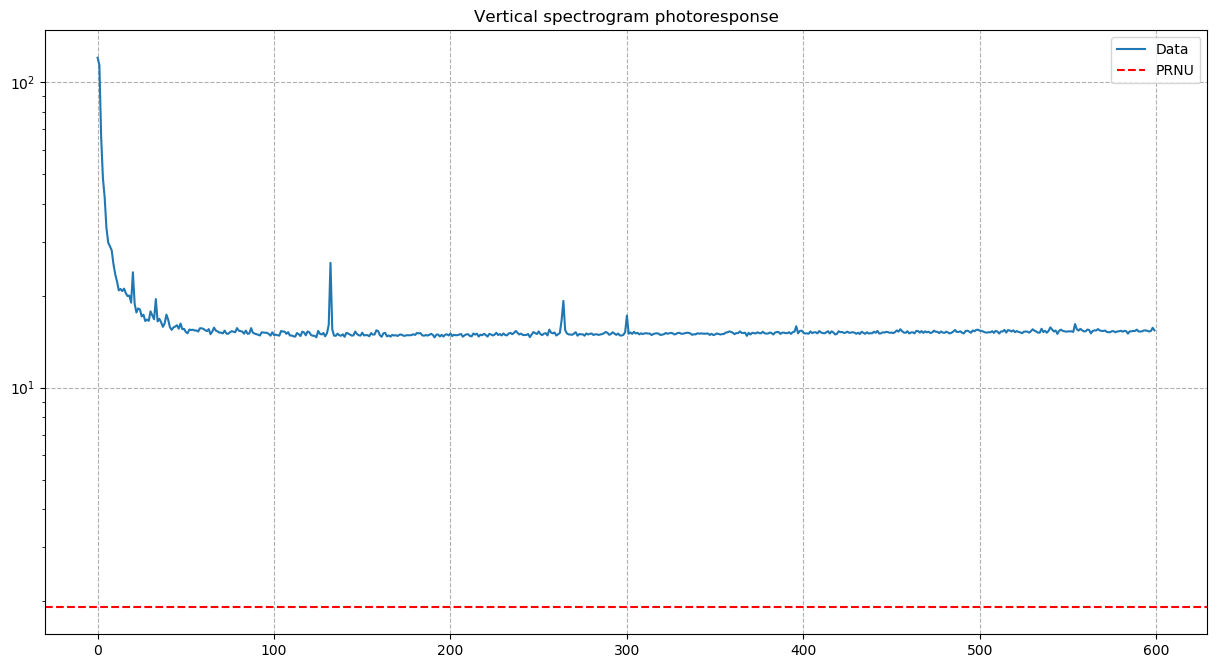

In [29]:
plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.title("Horizontal spectrogram photoresponse")
plt.semilogy(np.sqrt(fft_y_H)[:len(fft_y_H)//2],label="Data")
#plt.axhline(DSNU,linestyle='--',color="green",label="DSNU")
# PRNU wird in Prozent angegeben => *100
plt.axhline(PRNU*100,linestyle='--',color="red",label="PRNU")
plt.legend(loc='upper right')
plt.grid(linestyle="--")
plt.show()

plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.title("Vertical spectrogram photoresponse")
plt.semilogy(np.sqrt(fft_y_V)[:len(fft_y_V)//2],label="Data")
#plt.axhline(DSNU,linestyle='--',color="green",label="DSNU")
plt.axhline(PRNU*100,linestyle='--',color="red",label="PRNU")
plt.legend(loc='upper right')
plt.grid(linestyle="--")
plt.show()



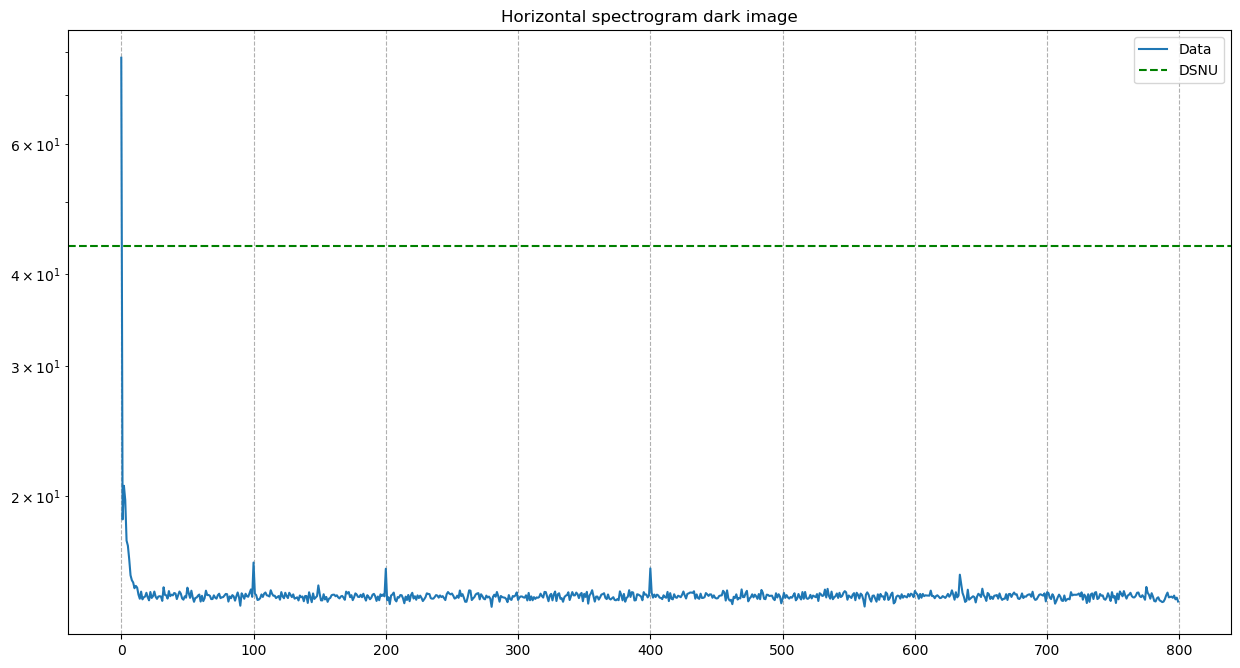

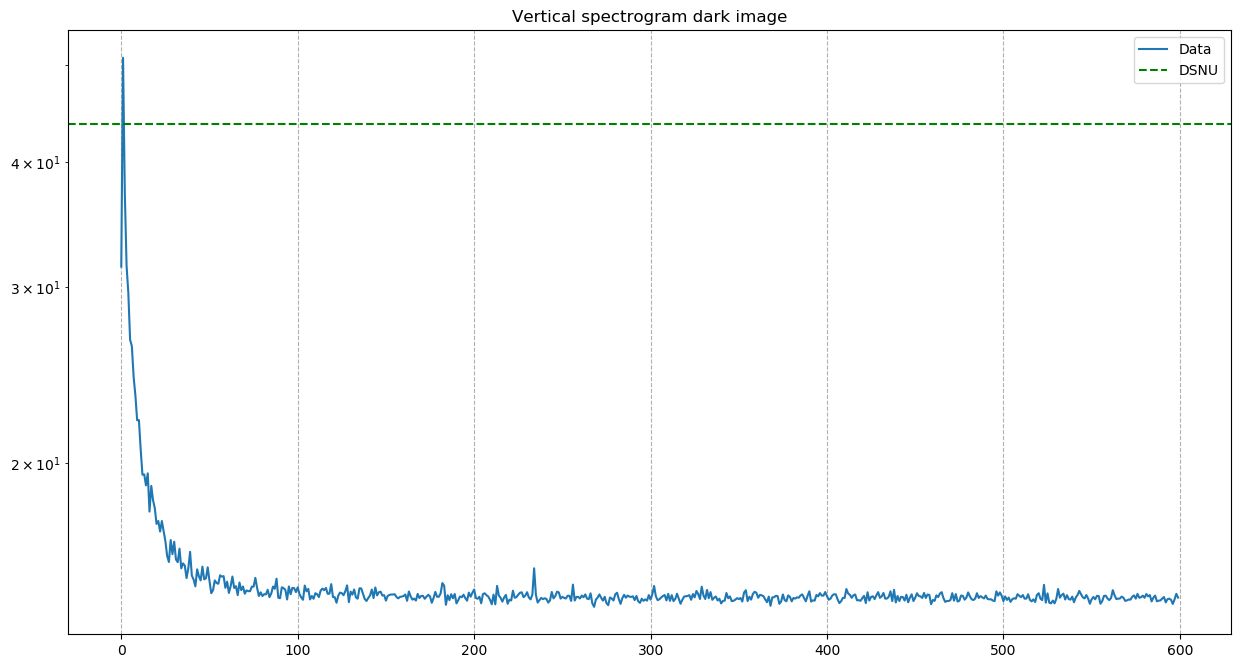

In [30]:

plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.title("Horizontal spectrogram dark image")
plt.semilogy(np.sqrt(fft_ydark_H)[:len(fft_ydark_H)//2],label="Data")
plt.axhline(DSNU,linestyle='--',color="green",label="DSNU")
#plt.axhline(PRNU,linestyle='--',color="red",label="PRNU")
plt.legend(loc='upper right')
plt.grid(linestyle="--")
plt.show()

plt.figure(figsize=(15,8),dpi=100,facecolor='w', edgecolor='k')
plt.title("Vertical spectrogram dark image")
plt.semilogy(np.sqrt(fft_ydark_V)[:len(fft_ydark_V)//2],label="Data")
plt.axhline(DSNU,linestyle='--',color="green",label="DSNU")
#plt.axhline(sigma2_dunkel_stack,linestyle='--',color="green",label="sigma2y,stack,dark")
#plt.axhline(PRNU,linestyle='--',color="red",label="PRNU")
plt.legend(loc='upper right')
plt.grid(linestyle="--")
plt.show()

### Hat Ihre Kamera periodische Inhomogenitäten?

So gut wie keine Inhomogenitäten sind erkennbar, es gibt zwar einige peaks, die sind aber nicht ausschlaggebend.

# Aufgabe 4: Defektpixel


### a)

    Erstellen Sie eine hochpassgefilterte Version Ihres Weißbildes aus Aufgabe 3.
    
---

### b)

    Berechnen Sie das logarithmierte DSNU-Histogramm aus dem Dunkelbild aus Aufgabe
    3 und das logarithmierte PRNU-Histogramm aus dem hochpassgefilterten Weißbild.
    
---

### c)

    Bestimmen Sie die Positionen der dead pixels in dem hochpassgefilterten Weißbild
    anhand eines aus dem PRNU-Histogramm gewählten Schwellwertes.

---

### d)

    Bestimmen Sie die Positionen der hot pixels und stuck pixels im Dunkelbild anhand
    eines aus dem DSNU-Histogramm gewählten Schwellwertes.

In [41]:
y_50 = y50_meanimg - y50_dark_meanimg
y_dark = y50_meanimg
highpassfilter = np.array( [ [1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1] ] ) / 25


y_filtered = y_50 - ndimage.convolve(y_50, highpassfilter, mode='constant')

y_max = y_filtered.max()
y_min = y_filtered.min()

#I = round()

20550.464 -10410.294000000002
